# Phase 2 — Feature-Engineered AQI Prediction

## Objective
The objective of Phase 2 is to predict Air Quality Index (AQI) using structured,
domain-informed features instead of raw pollutant measurements.

This phase introduces feature engineering to group related pollutants into indices
and evaluates how this restructuring impacts model behavior, interpretability,
and performance compared to the baseline model in Phase 1.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/city_day_data')

df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,01-01-2015,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,02-01-2015,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,03-01-2015,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,04-01-2015,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,05-01-2015,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
df.shape

(29531, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


## Dataset Overview
- Source: Public Kaggle air quality dataset
- Granularity: City-wise daily records
- Size: ~29,500 rows and 16 columns
- Target variable: AQI (continuous numerical value)

The dataset used in Phase 2 is the same as Phase 1 to ensure a fair comparison.


In [ ]:
df.isnull().sum()

,0
City,0
Date,0
PM2.5,4598
PM10,11140
NO,3582
NO2,3585
NOx,4185
NH3,10328
CO,2059
SO2,3854


## Feature Engineering Strategy

To reduce dimensionality and improve interpretability, pollutants were grouped based on
physical and chemical similarity:

- **PM_Index**: PM2.5, PM10  
- **Gas_Index**: NO, NO2, NOx, CO, SO2, O3  
- **VOC_Index**: Benzene, Toluene  

Pollutants with excessive missing values (e.g., NH₃, Xylene) were excluded to prevent
bias introduced by heavy imputation.

Each pollutant was normalized individually before aggregation to ensure equal contribution
within each index.


In [ ]:
target = 'AQI'

pm_pollutants = ['PM2.5', 'PM10']
gas_pollutants = ['NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']
voc_pollutants = ['Benzene', 'Toluene']

all_pollutants = pm_pollutants + gas_pollutants + voc_pollutants

In [ ]:
df_p2 = df[all_pollutants + [target]]

df_p2.head()

,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,Toluene,AQI
0,NaN,NaN,0.92,18.22,17.15,0.92,27.64,133.36,0.00,0.02,NaN
1,NaN,NaN,0.97,15.69,16.46,0.97,24.55,34.06,3.68,5.50,NaN
2,NaN,NaN,17.40,19.30,29.70,17.40,29.07,30.70,6.80,16.40,NaN
3,NaN,NaN,1.70,18.48,17.97,1.70,18.59,36.08,4.43,10.14,NaN
4,NaN,NaN,22.10,21.42,37.76,22.10,39.33,39.31,7.01,18.89,NaN


In [ ]:
df_p2.isnull().sum()

,0
PM2.5,4598
PM10,11140
NO,3582
NO2,3585
NOx,4185
CO,2059
SO2,3854
O3,4022
Benzene,5623
Toluene,8041


In [ ]:
df_p2 = df_p2.dropna(subset=[target])

df_p2.shape

(24850, 11)

In [ ]:
for col in all_pollutants:
    median_value = df_p2[col].median()
    df_p2[col] = df_p2[col].fillna(median_value)

In [ ]:
df_p2.isnull().sum()

,0
PM2.5,0
PM10,0
NO,0
NO2,0
NOx,0
CO,0
SO2,0
O3,0
Benzene,0
Toluene,0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_p2_scaled = df_p2.copy()

df_p2_scaled[all_pollutants] = scaler.fit_transform(df_p2[all_pollutants])

In [ ]:
df_p2_scaled['PM_Index'] = df_p2_scaled[pm_pollutants].mean(axis=1)

df_p2_scaled['Gas_Index'] = df_p2_scaled[gas_pollutants].mean(axis=1)

df_p2_scaled['VOC_Index'] = df_p2_scaled[voc_pollutants].mean(axis=1)

In [ ]:
features_p2 = ['PM_Index', 'Gas_Index', 'VOC_Index']

X = df_p2_scaled[features_p2]
y = df_p2_scaled[target]

X.head(), y.head()

(    PM_Index  Gas_Index  VOC_Index
 28  0.025449   0.576848  -0.325674
 29 -0.000964   1.115187  -0.325002
 30  0.116887   1.830487  -0.318006
 31  0.449808   2.679544  -0.311813
 32  0.789712   2.754626  -0.309254,
 28    209.0
 29    328.0
 30    514.0
 31    782.0
 32    914.0
 Name: AQI, dtype: float64)

## Data Cleaning and Normalization

Rows with missing target values (AQI) were removed.
Remaining missing values in pollutant features were imputed using the median to preserve
distributional robustness.

Standardization (z-score normalization) was applied **prior to index construction**
to ensure that no single pollutant dominated its respective index due to scale differences.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((19880, 3), (4970, 3))

## Train-Test Split
The dataset was split into training and testing sets using an 80–20 ratio.

This ensures that model evaluation reflects performance on unseen data.


## Modeling Approach
Three regression models were trained and compared:

- Linear Regression
- Ridge Regression
- Lasso Regression

These models allow evaluation of whether regularization improves performance
within the engineered feature space.


## Linear Regression

Linear Regression serves as the baseline model for Phase 2.
It evaluates whether the engineered indices preserve sufficient linear signal
for AQI prediction.


In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

rmse_lr, r2_lr

(np.float64(82.17192346643508), 0.6312480365454927)

## Ridge Regression

Ridge Regression introduces L2 regularization to penalize large coefficients.
Multiple regularization strengths (alpha values) were evaluated to assess
whether coefficient shrinkage improves model stability.


In [ ]:
from sklearn.linear_model import Ridge

ridge_alphas = [0.1, 1.0, 10.0, 50.0]

ridge_results = []

for alpha in ridge_alphas:
    model_ridge = Ridge(alpha=alpha)
    model_ridge.fit(X_train, y_train)

    y_pred_ridge = model_ridge.predict(X_test)

    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    r2_ridge = r2_score(y_test, y_pred_ridge)

    ridge_results.append((alpha, rmse_ridge, r2_ridge))

ridge_results

[(0.1, np.float64(82.17187585193027), 0.6312484638918735),
 (1.0, np.float64(82.1714478315902), 0.6312523054190429),
 (10.0, np.float64(82.16721800360412), 0.6312902674901808),
 (50.0, np.float64(82.14951230788894), 0.6314491522406349)]

## Lasso Regression

Lasso Regression applies L1 regularization, enabling both shrinkage and
implicit feature selection. This model evaluates whether sparsity improves
performance within the engineered feature space.


In [ ]:
from sklearn.linear_model import Lasso

lasso_alphas = [0.001, 0.01, 0.1, 1.0]

lasso_results = []

for alpha in lasso_alphas:
    model_lasso = Lasso(alpha=alpha, max_iter=10000)
    model_lasso.fit(X_train, y_train)

    y_pred_lasso = model_lasso.predict(X_test)

    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    r2_lasso = r2_score(y_test, y_pred_lasso)

    lasso_results.append((alpha, rmse_lasso, r2_lasso, model_lasso.coef_))

lasso_results

[(0.001,
  np.float64(82.17180704180463),
  0.6312490814712739,
  array([ 60.40669238, 115.72017254,   4.38050824])),
 (0.01,
  np.float64(82.17115263102365),
  0.6312549548632402,
  array([ 60.40104237, 115.70544034,   4.37240543])),
 (0.1,
  np.float64(82.16478214702559),
  0.6313121280505559,
  array([ 60.34454229, 115.55811828,   4.29137742])),
 (1.0,
  np.float64(82.11845280535746),
  0.6317277866888871,
  array([ 59.77954155, 114.08489772,   3.48109728]))]

In [45]:
best_ridge = min(ridge_results, key=lambda x: x[1])
best_ridge_alpha, best_ridge_rmse, best_ridge_r2 = best_ridge

best_lasso = min(lasso_results, key=lambda x: x[1])
best_lasso_alpha, best_lasso_rmse, best_lasso_r2, _ = best_lasso


## Model Comparison

The best-performing configuration of each model was selected based on
lowest RMSE on the test set.

The table below compares Linear Regression, Ridge Regression, and Lasso Regression
using RMSE and R² metrics.


In [46]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Lasso Regression"],
    "RMSE": [rmse_lr, best_ridge_rmse, best_lasso_rmse],
    "R² Score": [r2_lr, best_ridge_r2, best_lasso_r2]
})

comparison_df


,Model,RMSE,R² Score
0,Linear Regression,82.171923,0.631248
1,Ridge Regression,82.149512,0.631449
2,Lasso Regression,82.118453,0.631728


## Evaluation Summary

All three regression models exhibited **similar performance**, with only marginal
differences in RMSE and R² scores.

Compared to Phase 1, Phase 2 shows:
- Higher RMSE
- Lower R² scores

This performance change reflects **reduced variance and stricter feature constraints**
introduced by index-based feature engineering, rather than inferior modeling.

Phase 2 prioritizes **scientific validity and interpretability** over raw predictive power.


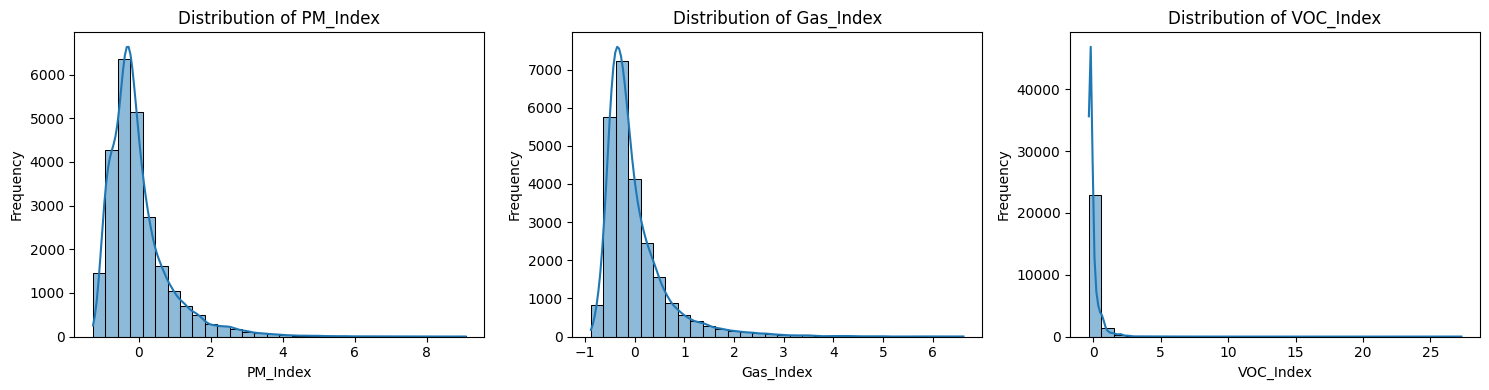

In [ ]:
features = ['PM_Index', 'Gas_Index', 'VOC_Index']

plt.figure(figsize=(15, 4))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_p2_scaled[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## EDA — Distribution of Engineered Indices
- PM Index and Gas Index show right-skewed distributions, indicating occasional
  pollution spikes.
- VOC Index exhibits very low variance, suggesting it acts primarily as a
  background contributor.

These distributions highlight differences in how pollutant groups behave
across days.


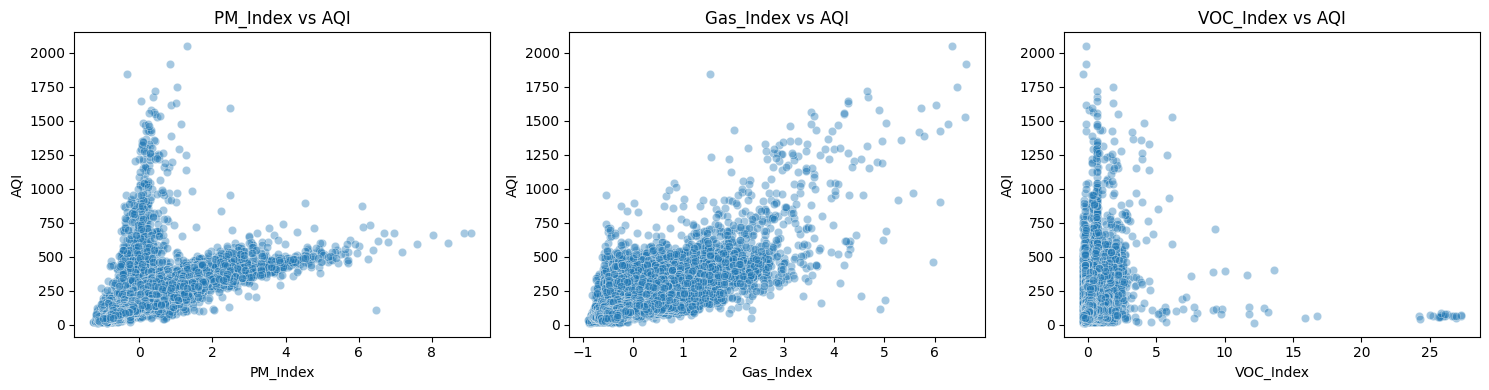

In [ ]:
plt.figure(figsize=(15, 4))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(
        x=df_p2_scaled[feature],
        y=df_p2_scaled[target],
        alpha=0.4
    )
    plt.title(f'{feature} vs AQI')
    plt.xlabel(feature)
    plt.ylabel('AQI')

plt.tight_layout()
plt.show()


## EDA — Index vs AQI Relationships
- PM and Gas indices dominate AQI variation at low to moderate AQI levels.
- Relationships weaken and become noisy at higher AQI values, indicating
  increased complexity during extreme pollution events.
- VOC Index shows minimal influence on AQI across ranges.



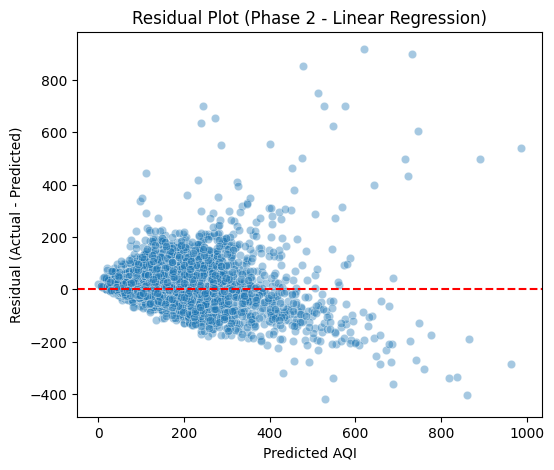

In [ ]:
residuals = y_test - y_pred_lr

plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_pred_lr, y=residuals, alpha=0.4)

plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted AQI')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot (Phase 2 - Linear Regression)')

plt.show()


## Residual Analysis
Residuals remain small and centered around zero for low to moderate AQI values,
indicating stable predictions under normal conditions.

At higher AQI levels, residual variance increases sharply, showing reduced model
reliability during extreme pollution events.



## Assumptions and Limitations

- Linear relationships are assumed between engineered indices and AQI.
- Temporal effects, city-specific patterns, and meteorological variables are not modeled.
- Model performance degrades during extreme pollution events.
- Index aggregation reduces noise but may discard fine-grained pollutant interactions.


## Conclusion

Phase 2 demonstrates that structured, theory-driven feature engineering leads to
more interpretable but statistically constrained models.

Although predictive performance decreased relative to Phase 1, the engineered indices
align more closely with environmental understanding, making Phase 2 a stronger
foundation for future extensions such as temporal modeling and non-linear approaches.

